# Impact of clustering on classification results, and stats

The purpose of this notebook is to observe how the data responds to being clustered by cd-hit at different thresholds.

In a second step, we perform deterministic randomized undersampling, to determine the smallest number of samples that leads to good classification results.

Then, we undersample the majority class, to test whether that makes its score approach that of the minority class.

Finally, we recreated some of the plots from Notebook 2, after a 70% cluster threshold has been applied.

## Imports

In [1]:
from subpred.transporter_dataset import create_dataset, get_clustering_stats
from subpred.compositions import calculate_aac, calculate_paac
from subpred.plots import (
    labeled_clustermap,
    pca_plot_2d,
    pca_plot_3d,
    feature_importance_plot,
    downsampling_plot, downsample_majority_class_plot
)
from subpred.cdhit import cd_hit
import seaborn as sns

In [2]:
df = create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Transmembrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "integrate",
    verbose = True,
    tax_ids_filter = [9606],
    output_log = "../logs/human_amino_sugar_dataset.log",
    outliers=["Q9HBR0", "Q07837"]
)

In [3]:
df_stats_long = get_clustering_stats(df)
df_stats_long

,identity_threshold,kw_type,keyword,count
0,40,keywords_location,Cell membrane,13
1,40,keywords_location,Endoplasmic reticulum,5
2,40,keywords_location,Membrane,47
3,40,keywords_location,Mitochondrion,5
4,40,keywords_location,Mitochondrion inner membrane,2
...,...,...,...,...
86,100,keywords_transport_related,Antiport,5
87,100,keywords_transport_related,Symport,24
88,100,keywords_transport_related,Transport,85
89,100,tcdb_class,0.0,2


In [4]:
def pivot(df_stats_long, kw_type):
    return df_stats_long[df_stats_long.kw_type == kw_type].pivot(
        index="identity_threshold", columns="keyword", values="count"
    ).fillna(0).convert_dtypes(int)

Not a lot of sugar transporters are removed until about 60% sequence similarity, then it drops sharply. This would probably be the lowest possible threshold.

keyword,Amino-acid transport,Sugar transport
identity_threshold,,
40,26,21
50,37,27
60,45,32
70,48,33
80,51,33
90,51,33
100,51,34


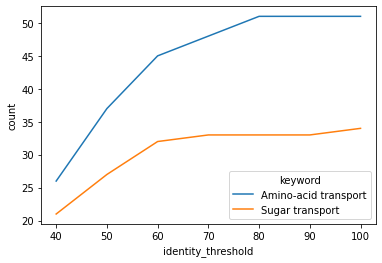

In [5]:
sns.lineplot(
    data=df_stats_long[df_stats_long.kw_type == "keywords_transport"],
    x="identity_threshold",
    y="count",
    hue="keyword",
)
pivot(df_stats_long, "keywords_transport")

Most of the proteins are removed from Cell Membrane:

keyword,Cell membrane,Endoplasmic reticulum,Membrane,Mitochondrion,Mitochondrion inner membrane,Transmembrane
identity_threshold,,,,,,
40,13,5,47,5,2,47
50,23,6,64,5,2,64
60,30,6,77,6,3,77
70,33,6,81,6,3,81
80,35,6,84,7,3,84
90,35,6,84,7,3,84
100,36,6,85,7,3,85


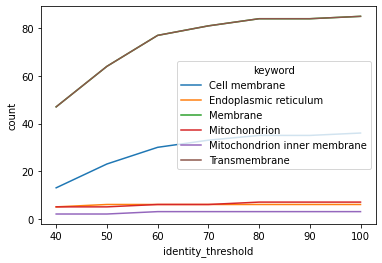

In [6]:
sns.lineplot(
    data=df_stats_long[df_stats_long.kw_type == "keywords_location"],
    x="identity_threshold",
    y="count",
    hue="keyword",
)
pivot(df_stats_long, "keywords_location")

Transport systems:

keyword,Antiport,Symport,Transport
identity_threshold,,,
40,3,11,47
50,4,18,64
60,5,22,77
70,5,23,81
80,5,24,84
90,5,24,84
100,5,24,85


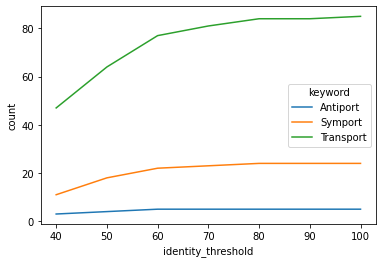

In [7]:
sns.lineplot(
    data=df_stats_long[df_stats_long.kw_type == "keywords_transport_related"],
    x="identity_threshold",
    y="count",
    hue="keyword",
)
pivot(df_stats_long, "keywords_transport_related")

Only one un-annotated transporter left at 70% threshold:

keyword,0.0,2.A
identity_threshold,,
40,1,46
50,1,63
60,1,76
70,1,80
80,2,82
90,2,82
100,2,83


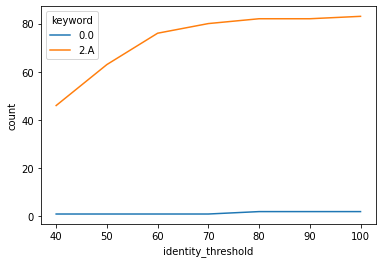

In [8]:
sns.lineplot(
    data=df_stats_long[df_stats_long.kw_type == "tcdb_class"],
    x="identity_threshold",
    y="count",
    hue="keyword",
)
pivot(df_stats_long, "tcdb_class")

The performance of sugar transporters is not very good to start with, it might already be to low for nested 5-fold cross validation. We will try LOOCV later.

<AxesSubplot:xlabel='Total Samples', ylabel='Score'>

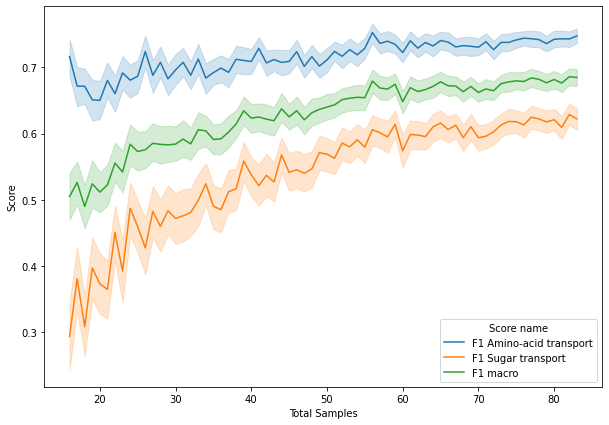

In [9]:
df_aac = calculate_aac(df.sequence)
labels = df.keywords_transport.rename("labels")

downsampling_plot(df_aac, labels)

When downsampling the majority class until the dataset is balanced, the performance starts to match that of the minority class. The number of samples in the minority class is likely the problem.

<AxesSubplot:xlabel='|Amino-acid transport|/|Sugar transport|', ylabel='Score'>

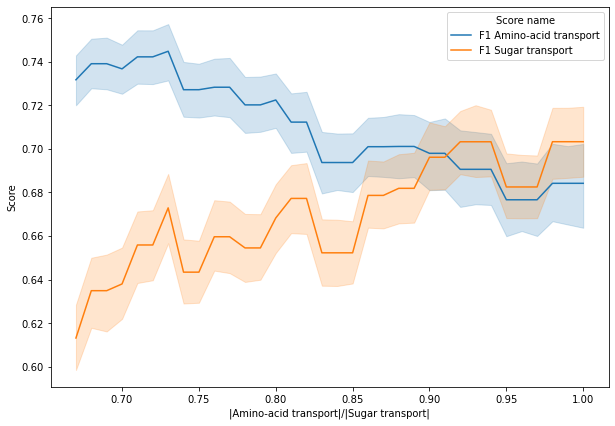

In [10]:
df_aac = calculate_aac(df.sequence)
labels = df.keywords_transport.rename("labels")
downsample_majority_class_plot(df_aac, labels, n_jobs=1, min_class_sample_fractions=[x / 100 for x in range(67,101)], include_macro=False)

## Plots at 70% cluster threshold


Four proteins are removed at 70% clustering threshold

In [11]:
cluster_representatives_70 = cd_hit(df.sequence, identity_threshold=70)
df_clustered = df.loc[cluster_representatives_70]

cd-hit: clustered 85 sequences into 81 clusters at threshold 70


In [12]:
df_aac_clustered = calculate_aac(df_clustered.sequence)
df_paac_clustered = calculate_paac(df_clustered.sequence)
labels_clustered = df_clustered.keywords_transport.rename("labels")

### Feature importance


In contrast to A thaliana, the clustering does not change the AAC in a significant way. This is because fewer samples are removed.

<AxesSubplot:xlabel='Feature', ylabel='Normalized score'>

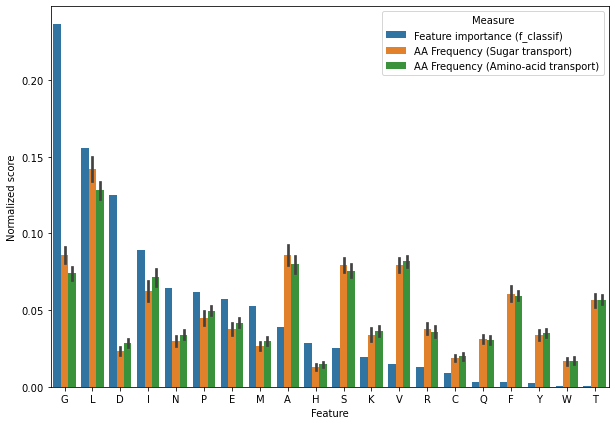

In [13]:
feature_importance_plot(df_aac_clustered, labels_clustered, method="f_classif")

### PCA



#### AAC

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

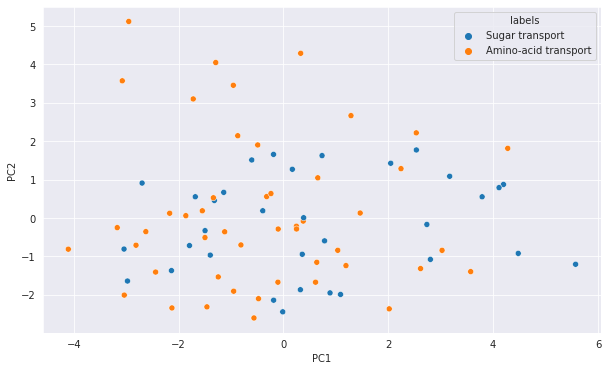

In [14]:
pca_plot_2d(df_aac_clustered, labels_clustered)

#### PAAC


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

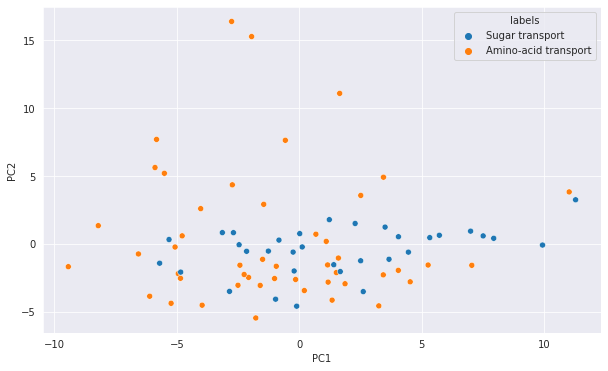

In [15]:
pca_plot_2d(df_paac_clustered, labels_clustered)

<Axes3DSubplot:xlabel='PC1', ylabel='PC2'>

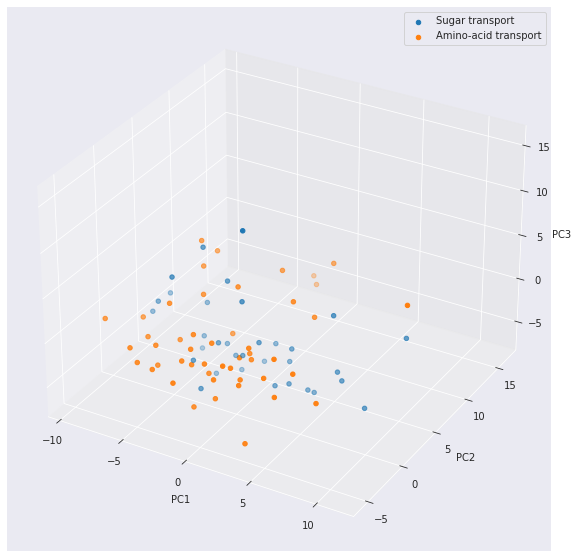

In [16]:
pca_plot_3d(df_paac_clustered, labels_clustered)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

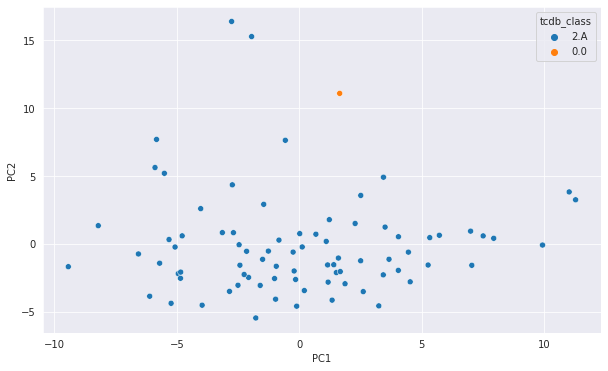

In [17]:
pca_plot_2d(df_paac_clustered, df.tcdb_class)

Three proteins with high PC2 are still in the dataset, they are Sideroflexins.

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

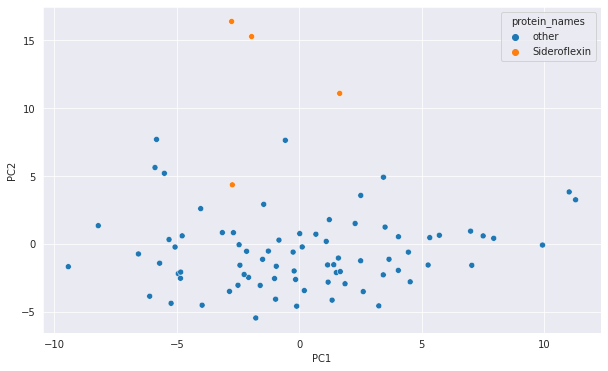

In [22]:
pca_plot_2d(df_paac_clustered, df.protein_names.transform(lambda x: "Sideroflexin" if "Sideroflexin" in x else "other"))

Nothing notable about other annotations

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

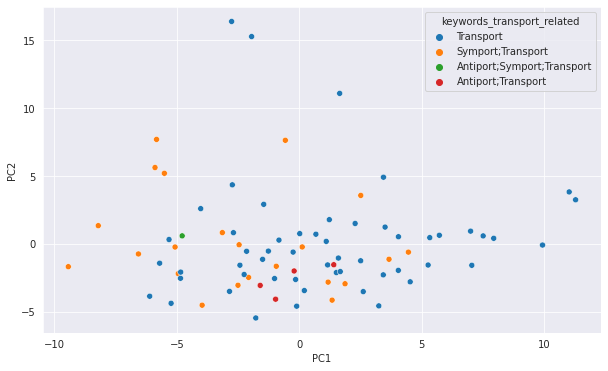

In [23]:
pca_plot_2d(df_paac_clustered, df.keywords_transport_related)

## Clustering heatmaps

Classes are still not separable very well through hierarchical clustering

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7f29db7a9160>)

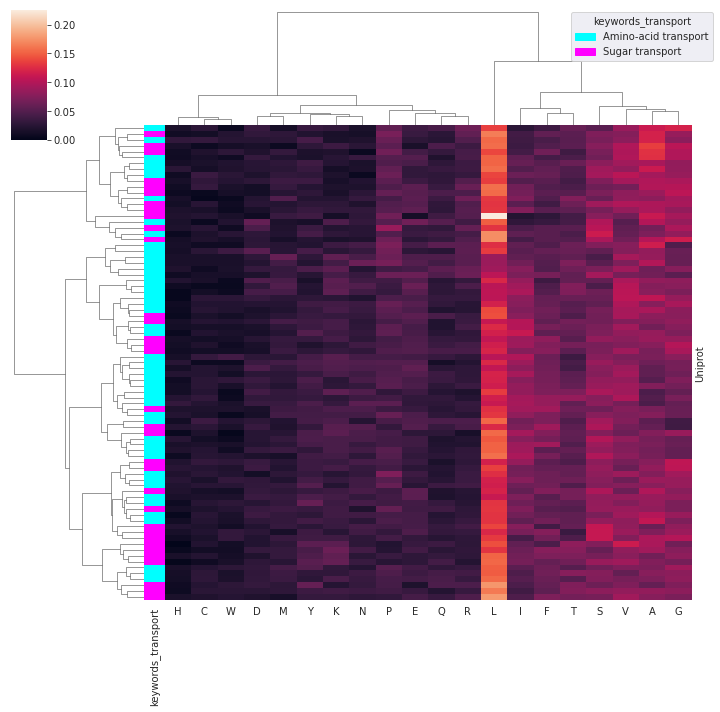

In [24]:
labeled_clustermap(df_aac_clustered, df_clustered.keywords_transport, xlabels="auto")

The same is true for paac:

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7f29db979a30>)

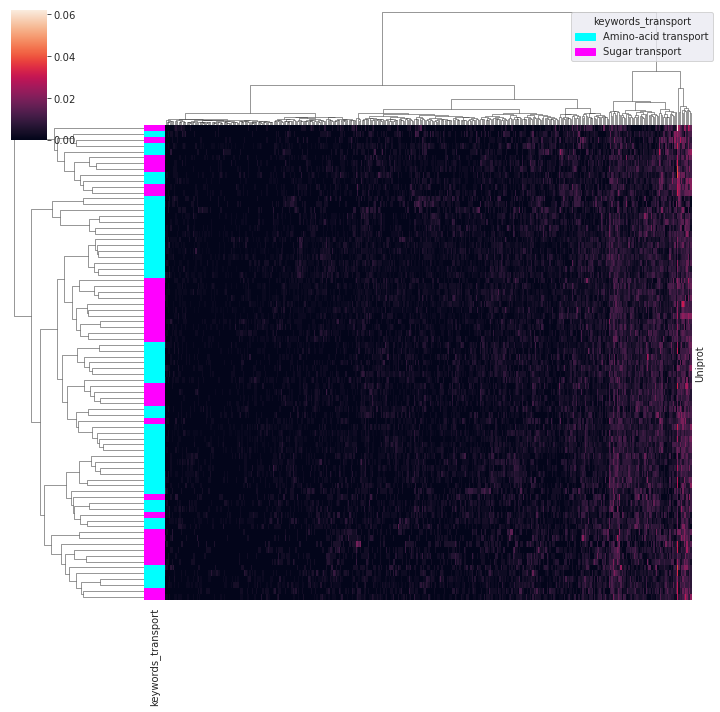

In [25]:
labeled_clustermap(df_paac_clustered, df_clustered.keywords_transport)

The remaining protein without TCDB entry is probably a porter:

({'0.0': 'cyan', '2.A': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7f29d5e72df0>)

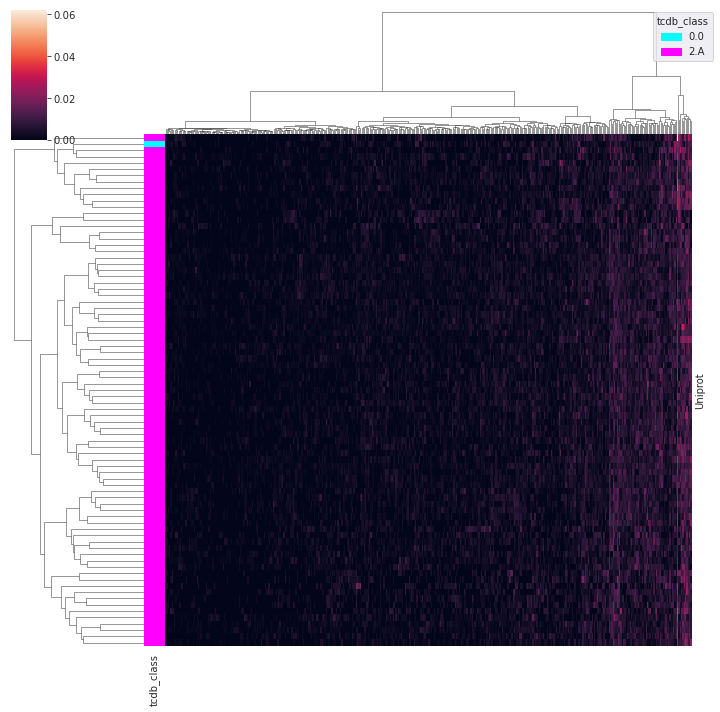

In [26]:
labeled_clustermap(df_paac_clustered, df_clustered.tcdb_class)

({'Antiport;Symport;Transport': 'cyan',
  'Antiport;Transport': 'magenta',
  'Symport;Transport': 'yellow',
  'Transport': 'green'},
 <seaborn.matrix.ClusterGrid at 0x7f29edb9a6a0>)

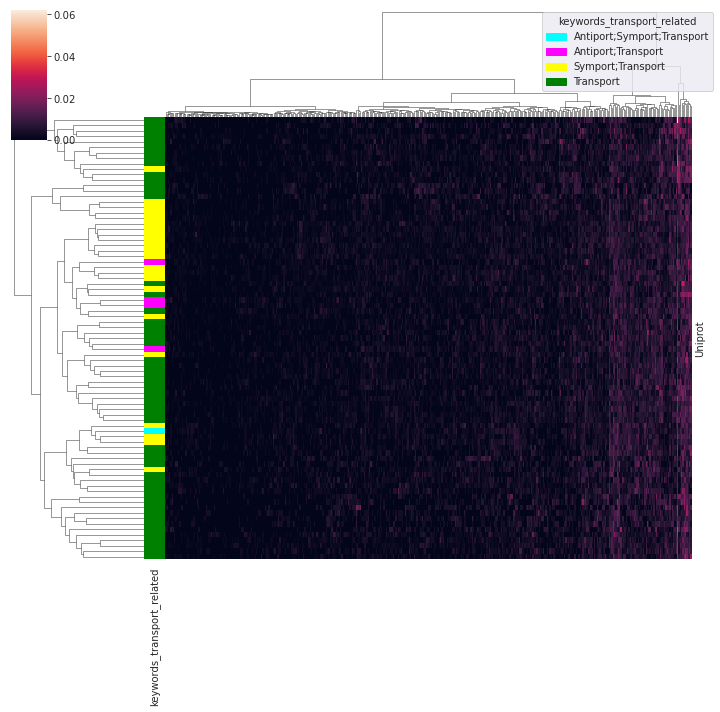

In [28]:
labeled_clustermap(df_paac_clustered, df_clustered.keywords_transport_related)